In [24]:
from sage.numerical.mip import MixedIntegerLinearProgram
import sys

def valid_parameters(n, k):
    if n < 1 or k < 0 or \
        n + k - 1 > (n * (n -1)) // 2 or \
        k > (n * (n -1)) // 2 - (n - 1):
        return False 
    return True

def min_problem_MILP(n, k, solver_name='GLPK', verbose=True):
    if not valid_parameters(n, k):
        print("Parameters not valid."); return 

    n = int(n); k = int(k)
    V = list(range(1, n+1)) # množica vozlišč
    E = [(i,j) for i in V for j in V if i < j] # množica povezav
    T = list(range(0, n)) # množica stopenj
    m_edges = n - 1 + k
    M_big = (n-1)**2 + 222
    root = 1

    # Ustvari MILP
    p = MixedIntegerLinearProgram(maximization=False, solver=solver_name)
    x = p.new_variable(binary=True)       # x[i,j] za i<j
    y = p.new_variable(binary=True)       # y[i,t]
    s = p.new_variable(nonnegative=True)  # s[i]
    z = p.new_variable(nonnegative=True)  # z[i,j]
    f = p.new_variable(nonnegative=True, integer=True)  # f[u,v]

    # One-hot kodiranje
    for i in V:
        p.add_constraint(sum(y[i,t] for t in T) == 1)

    # stopnja vozlišča je enaka številu sosedov
    for i in V:
        p.add_constraint(
            sum(x[min(i,j), max(i,j)] for j in V if j != i)
            == sum(t * y[i,t] for t in T)
        )

    # kvadrirana stopnja vozlišča
    for i in V:
        p.add_constraint(s[i] == sum((t*t) * y[i,t] for t in T))

    # graf ima natanko m povezav
    p.add_constraint(sum(x[i,j] for (i,j) in E) == m_edges)

    # modeliranje absolutne vrednosti
    for (i,j) in E:
        p.add_constraint(z[i,j] >= s[i] - s[j]- M_big * (1- x[i,j]))
        p.add_constraint(z[i,j] >= s[j] - s[i] - M_big * (1- x[i,j]))
        # p.add_constraint(z[i,j] <= M_big * x[i,j])

    # modeliranje povezanosti grafa
    for u in V:
        for v in V:
            if u == v: continue
            i,j = (u,v) if u < v else (v,u)
            p.add_constraint(f[u,v] <= (n-1) * x[i,j])

    for i in V:
        if i == root: continue
        p.add_constraint(
            sum(f[u,i] for u in V if u != i) - sum(f[i,v] for v in V if v != i) == 1
        )
    p.add_constraint(sum(f[root,v] for v in V if v != root) == n-1)

    # objektivna funkcija
    p.set_objective(sum(z[i,j] for (i,j) in E))

    try:
        p.solve()
    except Exception as e:
        print("Solver raised exception:", e)
        return None

    # Izlušči rešitev
    obj = p.get_objective_value()
    xvals = p.get_values(x)
    yvals = p.get_values(y)
    sval = p.get_values(s)
    edges = [e for e,v in xvals.items() if v > 0.5]
    deg = {}
    for i in V:
        for t in T:
            if yvals.get((i,t),0) > 0.5:
                deg[i] = t
                break

    if verbose:
        print("Solver objective:", obj)
        print("Edges (m=%d): %s" % (len(edges), sorted(edges)))
        print("Degrees:", deg)
    return dict(objective=obj, edges=edges, deg=deg, s=sval, raw_x=xvals, raw_y=yvals)


    
def draw_graph(res, filename=None, layout='spring'):
    if res is None:
        return
    print(res)
    edges = res['edges']
    G = Graph()
    for (i, j) in edges:
        G.add_edge(i, j)

    fig = G.plot(
        figsize=6,
        layout=layout,
        vertex_color='black',
        edge_color='black',
        vertex_labels=False,
        title=f"n={G.num_verts()}, k={G.num_edges() - G.num_verts() + 1}, objective={int(round(res['objective']))}"
    )
    if filename: 
        fig.save(filename)
    
    return fig.show()


Solver objective: 16.0
Edges (m=7): [(1, 3), (1, 5), (1, 6), (2, 3), (3, 6), (4, 5), (5, 6)]
Degrees: {1: 3, 2: 1, 3: 3, 4: 1, 5: 3, 6: 3}
{'objective': 16.0, 'edges': [(1, 3), (1, 5), (1, 6), (2, 3), (3, 6), (4, 5), (5, 6)], 'deg': {1: 3, 2: 1, 3: 3, 4: 1, 5: 3, 6: 3}, 's': {1: 9.0, 2: 1.0, 3: 9.0, 4: 1.0, 5: 9.0, 6: 9.0}, 'raw_x': {(1, 2): 0.0, (1, 3): 1.0, (1, 4): 0.0, (1, 5): 1.0, (1, 6): 1.0, (2, 3): 1.0, (2, 4): 0.0, (2, 5): 0.0, (2, 6): 0.0, (3, 4): 0.0, (3, 5): 0.0, (3, 6): 1.0, (4, 5): 1.0, (4, 6): 0.0, (5, 6): 1.0}, 'raw_y': {(1, 0): 0.0, (1, 1): 0.0, (1, 2): 0.0, (1, 3): 1.0, (1, 4): 0.0, (1, 5): 0.0, (2, 0): 0.0, (2, 1): 1.0, (2, 2): 0.0, (2, 3): 0.0, (2, 4): 0.0, (2, 5): 0.0, (3, 0): 0.0, (3, 1): 0.0, (3, 2): 0.0, (3, 3): 1.0, (3, 4): 0.0, (3, 5): 0.0, (4, 0): 0.0, (4, 1): 1.0, (4, 2): 0.0, (4, 3): 0.0, (4, 4): 0.0, (4, 5): 0.0, (5, 0): 0.0, (5, 1): 0.0, (5, 2): 0.0, (5, 3): 1.0, (5, 4): 0.0, (5, 5): 0.0, (6, 0): 0.0, (6, 1): 0.0, (6, 2): 0.0, (6, 3): 1.0, (6, 4): 0.0, (6,

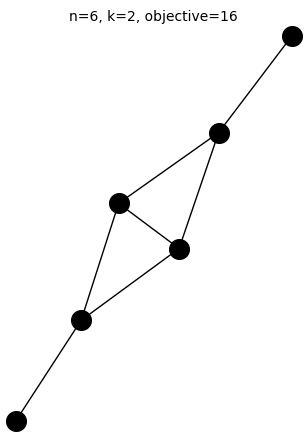

Solver objective: 16.0
Edges (m=8): [(1, 2), (1, 5), (1, 7), (2, 5), (2, 7), (3, 4), (3, 5), (6, 7)]
Degrees: {1: 3, 2: 3, 3: 2, 4: 1, 5: 3, 6: 1, 7: 3}
{'objective': 16.0, 'edges': [(1, 2), (1, 5), (1, 7), (2, 5), (2, 7), (3, 4), (3, 5), (6, 7)], 'deg': {1: 3, 2: 3, 3: 2, 4: 1, 5: 3, 6: 1, 7: 3}, 's': {1: 9.0, 2: 9.0, 3: 4.0, 4: 1.0, 5: 9.0, 6: 1.0, 7: 9.0}, 'raw_x': {(1, 2): 1.0, (1, 3): 0.0, (1, 4): 0.0, (1, 5): 1.0, (1, 6): 0.0, (1, 7): 1.0, (2, 3): 0.0, (2, 4): 0.0, (2, 5): 1.0, (2, 6): 0.0, (2, 7): 1.0, (3, 4): 1.0, (3, 5): 1.0, (3, 6): 0.0, (3, 7): 0.0, (4, 5): 0.0, (4, 6): 0.0, (4, 7): 0.0, (5, 6): 0.0, (5, 7): 0.0, (6, 7): 1.0}, 'raw_y': {(1, 0): 0.0, (1, 1): 0.0, (1, 2): 0.0, (1, 3): 1.0, (1, 4): 0.0, (1, 5): 0.0, (1, 6): 0.0, (2, 0): 0.0, (2, 1): 0.0, (2, 2): 0.0, (2, 3): 1.0, (2, 4): 0.0, (2, 5): 0.0, (2, 6): 0.0, (3, 0): 0.0, (3, 1): 0.0, (3, 2): 1.0, (3, 3): 0.0, (3, 4): 0.0, (3, 5): 0.0, (3, 6): 0.0, (4, 0): 0.0, (4, 1): 1.0, (4, 2): 0.0, (4, 3): 0.0, (4, 4): 0.0, (4, 5)

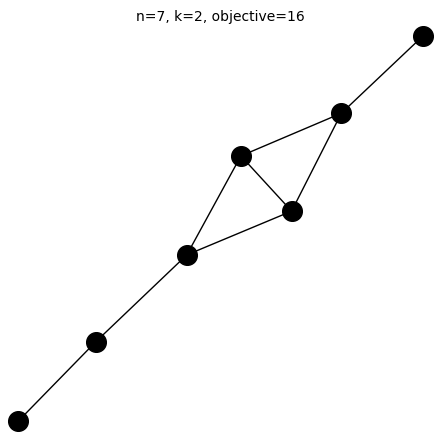

In [34]:
k = 2
for n in range(6, 8):
    draw_graph(min_problem_MILP(n,k), filename=f"images/cyclomatic-min/min_n{n}_k{k}.png")